# CNN-LSTM Hyperparameter Optimization
**Phase 2.5 - Trading RL Agent Development**

This notebook implements distributed hyperparameter optimization for the CNN-LSTM model used in financial time series prediction.

## 🎯 Objectives
- Test CNN-LSTM model architecture with sample trading data
- Implement comprehensive hyperparameter search space  
- Execute distributed optimization using Ray Tune
- Analyze results and identify optimal configurations

## 📋 Progress Tracker
- [ ] **Step 1**: Environment Setup & Data Loading
- [ ] **Step 2**: Model Architecture Validation
- [ ] **Step 3**: Training Pipeline Implementation
- [ ] **Step 4**: Hyperparameter Search Configuration
- [ ] **Step 5**: Ray Tune Integration & Execution
- [ ] **Step 6**: Results Analysis & Visualization

## 🚀 Step 1: Environment Setup & Data Loading

Setting up the Python environment and loading sample trading data for hyperparameter optimization.

In [4]:
# Environment Setup
import os
import sys
import warnings
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime

# Configure environment
warnings.filterwarnings('ignore')
plt.style.use('default')

# Add project root to Python path
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.append(project_root)

print("🔧 Environment Configuration:")
print(f"   • Project root: {project_root}")
print(f"   • Python version: {sys.version.split()[0]}")
print(f"   • PyTorch version: {torch.__version__}")
print(f"   • Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f"   • Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Import project modules
try:
    from src.models.cnn_lstm import CNNLSTMModel, CNNLSTMConfig, create_model
    from src.data_pipeline import PipelineConfig, load_data, generate_features, split_by_date
    print("✅ Project modules imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("   Ensure you're running from the project root directory")

print("\n" + "="*60)

🔧 Environment Configuration:
   • Project root: /workspaces/trading-rl-agent
   • Python version: 3.10.12
   • PyTorch version: 2.3.1+cu121
   • Device available: CPU
   • Timestamp: 2025-06-13 16:15:01
✅ Project modules imported successfully

✅ Project modules imported successfully



In [5]:
# Data Loading & Preparation
print("📊 Loading Sample Trading Data...")

# Load available sample data
data_files = [f for f in os.listdir('data/') if f.startswith('sample_training_data') and f.endswith('.csv')]
print(f"   • Available data files: {len(data_files)}")

if data_files:
    # Use the simple sample data for testing
    sample_file = 'data/sample_training_data_simple_20250607_192034.csv'
    
    try:
        df_sample = pd.read_csv(sample_file)
        print(f"✅ Data loaded successfully: {sample_file}")
        print(f"   • Shape: {df_sample.shape}")
        print(f"   • Columns: {list(df_sample.columns)}")
        print(f"   • Date range: {df_sample['timestamp'].iloc[0]} to {df_sample['timestamp'].iloc[-1]}")
        
        # Display sample data
        print("\n📋 Sample Data Preview:")
        print(df_sample.head(3))
        
        # Prepare feature data (OHLCV)
        feature_columns = ['open', 'high', 'low', 'close', 'volume']
        X_raw = df_sample[feature_columns].values.astype(np.float32)
        
        print(f"\n🔢 Feature Data:")
        print(f"   • Features: {feature_columns}")
        print(f"   • Shape: {X_raw.shape}")
        print(f"   • Data type: {X_raw.dtype}")
        
        # Check for any data quality issues
        print(f"   • NaN values: {np.isnan(X_raw).sum()}")
        print(f"   • Infinite values: {np.isinf(X_raw).sum()}")
        
        if np.isnan(X_raw).sum() > 0 or np.isinf(X_raw).sum() > 0:
            print("⚠️  Data quality issues detected - may need cleaning")
        else:
            print("✅ Data quality checks passed")
            
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        df_sample = None
        X_raw = None
else:
    print("❌ No sample data files found")
    print("   Run generate_sample_data.py to create sample data")
    df_sample = None
    X_raw = None

print("\n" + "="*60)

📊 Loading Sample Trading Data...
   • Available data files: 2
✅ Data loaded successfully: data/sample_training_data_simple_20250607_192034.csv
   • Shape: (721, 7)
   • Columns: ['timestamp', 'symbol', 'open', 'high', 'low', 'close', 'volume']
   • Date range: 2025-05-10 19:51:32.958494 to 2025-06-09 19:51:32.958494

📋 Sample Data Preview:
                    timestamp symbol        open        high         low  \
0  2025-05-10 19:51:32.958494   TEST   99.828983  100.679873   99.352123   
1  2025-05-10 20:51:32.958494   TEST  100.362460  101.971418   99.074884   
2  2025-05-10 21:51:32.958494   TEST  100.740771  102.329972  100.740771   

       close  volume  
0  100.49795  176185  
1  100.66595  850668  
2  101.92260  844852  

🔢 Feature Data:
   • Features: ['open', 'high', 'low', 'close', 'volume']
   • Shape: (721, 5)
   • Data type: float32
   • NaN values: 0
   • Infinite values: 0
✅ Data quality checks passed



## 🏗️ Step 2: Model Architecture Validation

Testing the CNN-LSTM model architecture with our sample data to ensure compatibility before hyperparameter optimization.

In [6]:
# Model Architecture Validation
if X_raw is not None:
    print("🏗️ Creating and Testing CNN-LSTM Model...")
    
    # Prepare sequence data for time series prediction
    sequence_length = 30  # Use 30 time steps for this test
    step_size = 1
    
    print(f"   • Sequence length: {sequence_length}")
    print(f"   • Feature dimensions: {X_raw.shape[1]}")
    
    # Create sequences
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X_raw) - sequence_length):
        X_sequences.append(X_raw[i:i + sequence_length])
        # Predict next close price (index 3 in OHLCV)
        y_sequences.append(X_raw[i + sequence_length, 3])
    
    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.float32)
    
    print(f"   • Sequence data shape: X={X_sequences.shape}, y={y_sequences.shape}")
    
    # Create test model configuration
    test_config = CNNLSTMConfig(
        input_dim=X_sequences.shape[-1],  # Number of features (5 for OHLCV)
        output_size=1,                    # Single prediction output
        cnn_filters=[32, 64],            # CNN layer sizes
        cnn_kernel_sizes=[3, 3],         # Kernel sizes for each CNN layer
        lstm_units=50,                   # LSTM hidden units
        dropout=0.2,                     # Dropout rate
        use_attention=False              # No attention for simplicity
    )
    
    print(f"\n🔧 Model Configuration:")
    print(f"   • Input dimensions: {test_config.input_dim}")
    print(f"   • CNN filters: {test_config.cnn_filters}")
    print(f"   • CNN kernels: {test_config.cnn_kernel_sizes}")
    print(f"   • LSTM units: {test_config.lstm_units}")
    print(f"   • Dropout: {test_config.dropout}")
    
    # Create and test model
    try:
        model = create_model(test_config)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        print(f"\n✅ Model created successfully on {device}")
        print(f"   • Model parameters: {sum(p.numel() for p in model.parameters()):,}")
        
        # Test forward pass
        test_batch_size = 8
        X_test = torch.FloatTensor(X_sequences[:test_batch_size]).to(device)
        
        with torch.no_grad():
            test_output = model(X_test)
        
        print(f"   • Forward pass successful")
        print(f"   • Input shape: {X_test.shape}")
        print(f"   • Output shape: {test_output.shape}")
        print(f"   • Sample predictions: {test_output.flatten()[:3].cpu().numpy()}")
        
        architecture_validated = True
        
    except Exception as e:
        print(f"❌ Model architecture error: {e}")
        architecture_validated = False
        import traceback
        traceback.print_exc()
        
else:
    print("⚠️  Skipping model validation - no data available")
    architecture_validated = False

print("\n" + "="*60)

🏗️ Creating and Testing CNN-LSTM Model...
   • Sequence length: 30
   • Feature dimensions: 5
   • Sequence data shape: X=(691, 30, 5), y=(691,)

🔧 Model Configuration:
   • Input dimensions: 5
   • CNN filters: [32, 64]
   • CNN kernels: [3, 3]
   • LSTM units: 50
   • Dropout: 0.2

✅ Model created successfully on cpu
   • Model parameters: 29,971
   • Forward pass successful
   • Input shape: torch.Size([8, 30, 5])
   • Output shape: torch.Size([8, 1])
   • Sample predictions: [0.49776834 0.5130266  0.8592828 ]



## 🚄 Step 3: Training Pipeline Implementation

Implementing the training pipeline that will be used for hyperparameter optimization.

In [7]:
# Training Pipeline Implementation
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def train_cnn_lstm_model(config, X_data, y_data, num_epochs=10, verbose=True):
    """
    Complete training pipeline for CNN-LSTM model.
    
    Args:
        config: CNNLSTMConfig object with model hyperparameters
        X_data: Input sequences (samples, sequence_length, features)
        y_data: Target values (samples,)
        num_epochs: Number of training epochs
        verbose: Print training progress
    
    Returns:
        dict: Training results including losses and model
    """
    if verbose:
        print(f"🚄 Training CNN-LSTM Model...")
        print(f"   • Data shape: X={X_data.shape}, y={y_data.shape}")
        print(f"   • Epochs: {num_epochs}")
    
    # Data preprocessing
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Normalize features
    X_flat = X_data.reshape(-1, X_data.shape[-1])
    X_normalized = scaler_X.fit_transform(X_flat).reshape(X_data.shape)
    y_normalized = scaler_y.fit_transform(y_data.reshape(-1, 1)).flatten()
    
    # Train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_normalized, y_normalized, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Convert to tensors
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Create model
    model = create_model(config).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        num_batches = 0
        batch_size = 32
        
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i + batch_size]
            batch_y = y_train_tensor[i:i + batch_size]
            
            if len(batch_X) < 2:  # Skip very small batches
                continue
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = train_loss / max(num_batches, 1)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs.squeeze(), y_val_tensor).item()
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        
        if verbose and (epoch % 5 == 0 or epoch == num_epochs - 1):
            print(f"   Epoch {epoch+1:2d}/{num_epochs} - Train: {avg_train_loss:.6f}, Val: {val_loss:.6f}")
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'scalers': (scaler_X, scaler_y)
    }

# Test the training pipeline
if architecture_validated and X_sequences is not None:
    print("🧪 Testing Training Pipeline...")
    
    # Test with a quick training run
    test_config = CNNLSTMConfig(
        input_dim=X_sequences.shape[-1],
        output_size=1,
        cnn_filters=[16, 32],
        cnn_kernel_sizes=[3, 3],
        lstm_units=32,
        dropout=0.1,
        use_attention=False
    )
    
    try:
        results = train_cnn_lstm_model(
            config=test_config,
            X_data=X_sequences,
            y_data=y_sequences,
            num_epochs=5,
            verbose=True
        )
        
        print(f"\n✅ Training pipeline test successful!")
        print(f"   • Final train loss: {results['final_train_loss']:.6f}")
        print(f"   • Final val loss: {results['final_val_loss']:.6f}")
        print(f"   • Best val loss: {results['best_val_loss']:.6f}")
        
        training_pipeline_ready = True
        
    except Exception as e:
        print(f"❌ Training pipeline error: {e}")
        training_pipeline_ready = False
        import traceback
        traceback.print_exc()
else:
    print("⚠️  Skipping training pipeline test - architecture not validated")
    training_pipeline_ready = False

print("\n" + "="*60)

🧪 Testing Training Pipeline...
🚄 Training CNN-LSTM Model...
   • Data shape: X=(691, 30, 5), y=(691,)
   • Epochs: 5
   Epoch  1/5 - Train: 0.029806, Val: 5.197355
   Epoch  1/5 - Train: 0.029806, Val: 5.197355
   Epoch  5/5 - Train: 0.000662, Val: 4.921072

✅ Training pipeline test successful!
   • Final train loss: 0.000662
   • Final val loss: 4.921072
   • Best val loss: 4.921072

   Epoch  5/5 - Train: 0.000662, Val: 4.921072

✅ Training pipeline test successful!
   • Final train loss: 0.000662
   • Final val loss: 4.921072
   • Best val loss: 4.921072



## 🔍 Step 4: Hyperparameter Search Configuration

Defining the search space and strategies for hyperparameter optimization.

In [8]:
# Hyperparameter Search Configuration
print("🔍 Defining Hyperparameter Search Space...")

# Define comprehensive search space
def get_hyperparameter_search_space():
    """Define the hyperparameter search space for CNN-LSTM optimization."""
    return {
        # Architecture parameters
        "cnn_filters": [
            [16, 32],
            [32, 64], 
            [64, 128],
            [16, 32, 64]
        ],
        "cnn_kernel_sizes": [
            [3, 3],
            [3, 5],
            [5, 5],
            [3, 3, 3]  # For 3-layer CNN
        ],
        "lstm_units": [32, 50, 64, 100, 128],
        "dropout": [0.1, 0.2, 0.3, 0.4],
        
        # Training parameters
        "learning_rate": [0.0001, 0.0005, 0.001, 0.005, 0.01],
        "batch_size": [16, 32, 64],
        "num_epochs": [10, 15, 20]
    }

# Get search space
search_space = get_hyperparameter_search_space()

print("📊 Hyperparameter Search Space:")
for param, values in search_space.items():
    print(f"   • {param:15} : {len(values)} options")
    if len(values) <= 5:
        print(f"     {values}")
    else:
        print(f"     {values[:3]}...{values[-2:]}")

# Calculate search space size
total_combinations = 1
for param, values in search_space.items():
    total_combinations *= len(values)

print(f"\n📈 Search Space Statistics:")
print(f"   • Total parameters: {len(search_space)}")
print(f"   • Total combinations: {total_combinations:,}")
print(f"   • Estimated time (5min/trial): {total_combinations * 5 / 60:.1f} hours")

# Define optimization strategy
print(f"\n⚡ Optimization Strategy:")
print(f"   • Algorithm: Random Search + Early Stopping")
print(f"   • Trials: 20-50 (subset of full space)")
print(f"   • Early stopping: ASHA scheduler")
print(f"   • Metric: Validation loss")
print(f"   • Mode: Minimize")

# Create Ray Tune compatible search space
def get_ray_tune_search_space():
    """Convert search space to Ray Tune format."""
    try:
        from ray import tune
        return {
            "cnn_filters": tune.choice([
                [16, 32],
                [32, 64], 
                [64, 128]
            ]),
            "cnn_kernel_sizes": tune.choice([
                [3, 3],
                [3, 5],
                [5, 5]
            ]),
            "lstm_units": tune.choice([32, 50, 64, 100]),
            "dropout": tune.uniform(0.1, 0.4),
            "learning_rate": tune.loguniform(1e-4, 1e-2),
            "batch_size": tune.choice([16, 32, 64]),
            "num_epochs": tune.choice([10, 15, 20])
        }
    except ImportError:
        print("   Ray Tune not available - will use manual search")
        return None

ray_search_space = get_ray_tune_search_space()

if ray_search_space:
    print(f"✅ Ray Tune search space created")
else:
    print(f"⚠️  Ray Tune search space not available")

print("\n" + "="*60)

🔍 Defining Hyperparameter Search Space...
📊 Hyperparameter Search Space:
   • cnn_filters     : 4 options
     [[16, 32], [32, 64], [64, 128], [16, 32, 64]]
   • cnn_kernel_sizes : 4 options
     [[3, 3], [3, 5], [5, 5], [3, 3, 3]]
   • lstm_units      : 5 options
     [32, 50, 64, 100, 128]
   • dropout         : 4 options
     [0.1, 0.2, 0.3, 0.4]
   • learning_rate   : 5 options
     [0.0001, 0.0005, 0.001, 0.005, 0.01]
   • batch_size      : 3 options
     [16, 32, 64]
   • num_epochs      : 3 options
     [10, 15, 20]

📈 Search Space Statistics:
   • Total parameters: 7
   • Total combinations: 14,400
   • Estimated time (5min/trial): 1200.0 hours

⚡ Optimization Strategy:
   • Algorithm: Random Search + Early Stopping
   • Trials: 20-50 (subset of full space)
   • Early stopping: ASHA scheduler
   • Metric: Validation loss
   • Mode: Minimize
✅ Ray Tune search space created



## ⚡ Step 5: Ray Tune Integration & Execution

Setting up distributed hyperparameter optimization with Ray Tune.

In [9]:
# Ray Tune Integration & Setup
print("⚡ Setting up Ray Tune for Distributed Optimization...")

# Ray initialization with robust error handling
def initialize_ray():
    """Initialize Ray with fallback strategies."""
    try:
        import ray
        
        # Check if Ray is already running
        if ray.is_initialized():
            print("   • Ray already initialized")
            return True
            
        # Try to start Ray
        ray.init(ignore_reinit_error=True, log_to_driver=False)
        print(f"   • Ray initialized successfully")
        print(f"   • Available resources: {ray.available_resources()}")
        return True
        
    except Exception as e:
        print(f"   ❌ Ray initialization failed: {e}")
        return False

ray_available = initialize_ray()

# Define Ray Tune training function
def ray_tune_train_function(config):
    """Training function compatible with Ray Tune."""
    from ray import train
    
    # Create model config from Ray Tune hyperparameters
    model_config = CNNLSTMConfig(
        input_dim=X_sequences.shape[-1],
        output_size=1,
        cnn_filters=config["cnn_filters"],
        cnn_kernel_sizes=config["cnn_kernel_sizes"],
        lstm_units=config["lstm_units"],
        dropout=config["dropout"],
        use_attention=False
    )
    
    # Train model
    results = train_cnn_lstm_model(
        config=model_config,
        X_data=X_sequences,
        y_data=y_sequences,
        num_epochs=config["num_epochs"],
        verbose=False  # Reduce output for Ray Tune
    )
    
    # Report metrics to Ray Tune
    train.report({
        "train_loss": results["final_train_loss"],
        "val_loss": results["final_val_loss"], 
        "best_val_loss": results["best_val_loss"]
    })

# Configure Ray Tune experiment
def setup_ray_tune_experiment(num_samples=12, max_concurrent_trials=3):
    """Setup Ray Tune experiment configuration."""
    if not ray_available:
        print("   ❌ Ray not available - cannot setup experiment")
        return None, None, None
    
    try:
        from ray import tune
        from ray.tune.schedulers import ASHAScheduler
        
        # Early stopping scheduler
        scheduler = ASHAScheduler(
            metric="val_loss",
            mode="min",
            max_t=20,  # Maximum epochs
            grace_period=5,  # Minimum epochs before stopping
            reduction_factor=2
        )
        
        # Create output directory
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = f"./ray_results/cnn_lstm_hparam_{timestamp}"
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"   ✅ Ray Tune experiment configured:")
        print(f"      • Scheduler: ASHA (early stopping)")
        print(f"      • Number of trials: {num_samples}")
        print(f"      • Max concurrent: {max_concurrent_trials}")
        print(f"      • Output directory: {output_dir}")
        
        return scheduler, output_dir, True
        
    except ImportError as e:
        print(f"   ❌ Ray Tune not available: {e}")
        return None, None, False

# Setup experiment
if ray_available and training_pipeline_ready:
    scheduler, output_dir, tune_ready = setup_ray_tune_experiment()
    print(f"   Ray Tune setup: {'✅ Ready' if tune_ready else '❌ Failed'}")
else:
    tune_ready = False
    print("   ⚠️  Ray Tune setup skipped - prerequisites not met")

print("\n" + "="*60)

2025-06-13 16:15:52,677	INFO worker.py:1631 -- Connecting to existing Ray cluster at address: 172.17.0.2:6379...
2025-06-13 16:15:52,688	INFO worker.py:1816 -- Connected to Ray cluster.
2025-06-13 16:15:52,688	INFO worker.py:1816 -- Connected to Ray cluster.


⚡ Setting up Ray Tune for Distributed Optimization...
   • Ray initialized successfully
   • Available resources: {'object_store_memory': 8699569766.0, 'CPU': 4.0, 'node:172.17.0.2': 1.0, 'node:__internal_head__': 1.0, 'memory': 17399139534.0}
   ✅ Ray Tune experiment configured:
      • Scheduler: ASHA (early stopping)
      • Number of trials: 12
      • Max concurrent: 3
      • Output directory: ./ray_results/cnn_lstm_hparam_20250613_161552
   Ray Tune setup: ✅ Ready



In [10]:
# Execute Hyperparameter Optimization
print("🚀 Executing CNN-LSTM Hyperparameter Optimization...")
print(f"   Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

optimization_results = None
best_config = None

if tune_ready and ray_search_space:
    print("\n⚡ Running Ray Tune Optimization...")
    
    try:
        from ray import tune
        
        # Run hyperparameter optimization
        analysis = tune.run(
            ray_tune_train_function,
            config=ray_search_space,
            scheduler=scheduler,
            num_samples=12,  # Number of trials
            resources_per_trial={"cpu": 1, "gpu": 0},
            storage_path=os.path.abspath(output_dir),
            name="cnn_lstm_optimization",
            verbose=1,
            raise_on_failed_trial=False
        )
        
        print("\n✅ Ray Tune optimization completed!")
        
        # Extract results
        results_df = analysis.results_df
        
        if len(results_df) > 0 and 'val_loss' in results_df.columns:
            # Get best trial
            successful_trials = results_df[results_df['val_loss'].notna()]
            
            if len(successful_trials) > 0:
                best_idx = successful_trials['val_loss'].idxmin()
                best_trial = successful_trials.loc[best_idx]
                
                best_config = {
                    'cnn_filters': best_trial.get('config/cnn_filters'),
                    'cnn_kernel_sizes': best_trial.get('config/cnn_kernel_sizes'),
                    'lstm_units': best_trial.get('config/lstm_units'),
                    'dropout': best_trial.get('config/dropout'),
                    'learning_rate': best_trial.get('config/learning_rate'),
                    'batch_size': best_trial.get('config/batch_size'),
                    'num_epochs': best_trial.get('config/num_epochs')
                }
                
                print(f"\n🏆 Best Configuration Found:")
                print(f"   • Validation Loss: {best_trial['val_loss']:.6f}")
                for key, value in best_config.items():
                    print(f"   • {key}: {value}")
                
                optimization_results = {
                    'method': 'Ray Tune',
                    'results_df': results_df,
                    'best_config': best_config,
                    'best_val_loss': best_trial['val_loss'],
                    'total_trials': len(results_df),
                    'successful_trials': len(successful_trials)
                }
            else:
                print("❌ No successful trials found")
        else:
            print("❌ No valid results returned from Ray Tune")
            
    except Exception as e:
        print(f"❌ Ray Tune execution failed: {e}")
        tune_ready = False

# Fallback: Manual grid search
if not tune_ready or optimization_results is None:
    print("\n🔧 Running Manual Grid Search (Fallback)...")
    
    # Define a smaller search space for manual testing
    manual_search_configs = [
        {
            'cnn_filters': [32, 64],
            'cnn_kernel_sizes': [3, 3],
            'lstm_units': 50,
            'dropout': 0.2,
            'learning_rate': 0.001,
            'batch_size': 32,
            'num_epochs': 10
        },
        {
            'cnn_filters': [16, 32],
            'cnn_kernel_sizes': [3, 3], 
            'lstm_units': 32,
            'dropout': 0.1,
            'learning_rate': 0.005,
            'batch_size': 16,
            'num_epochs': 10
        },
        {
            'cnn_filters': [64, 128],
            'cnn_kernel_sizes': [3, 5],
            'lstm_units': 100,
            'dropout': 0.3,
            'learning_rate': 0.0005,
            'batch_size': 64,
            'num_epochs': 15
        }
    ]
    
    manual_results = []
    best_val_loss = float('inf')
    
    for i, config in enumerate(manual_search_configs):
        print(f"\n   Trial {i+1}/{len(manual_search_configs)}: {config['cnn_filters']}, {config['lstm_units']} units")
        
        try:
            # Create model config
            model_config = CNNLSTMConfig(
                input_dim=X_sequences.shape[-1],
                output_size=1,
                cnn_filters=config['cnn_filters'],
                cnn_kernel_sizes=config['cnn_kernel_sizes'],
                lstm_units=config['lstm_units'],
                dropout=config['dropout'],
                use_attention=False
            )
            
            # Train model
            results = train_cnn_lstm_model(
                config=model_config,
                X_data=X_sequences,
                y_data=y_sequences,
                num_epochs=config['num_epochs'],
                verbose=False
            )
            
            # Store results
            trial_result = config.copy()
            trial_result.update({
                'val_loss': results['final_val_loss'],
                'train_loss': results['final_train_loss'],
                'best_val_loss': results['best_val_loss']
            })
            manual_results.append(trial_result)
            
            if results['final_val_loss'] < best_val_loss:
                best_val_loss = results['final_val_loss']
                best_config = config.copy()
            
            print(f"      ✅ Val Loss: {results['final_val_loss']:.6f}")
            
        except Exception as e:
            print(f"      ❌ Trial failed: {e}")
    
    if manual_results:
        optimization_results = {
            'method': 'Manual Grid Search',
            'results': manual_results,
            'best_config': best_config,
            'best_val_loss': best_val_loss,
            'total_trials': len(manual_search_configs),
            'successful_trials': len(manual_results)
        }
        
        print(f"\n🏆 Manual Search Best Configuration:")
        print(f"   • Validation Loss: {best_val_loss:.6f}")
        for key, value in best_config.items():
            print(f"   • {key}: {value}")

print("\n" + "="*60)

2025-06-13 16:16:27,621	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/workspaces/trading-rl-agent/ray_results/cnn_lstm_hparam_20250613_161552/cnn_lstm_optimization' in 0.0921s.
2025-06-13 16:16:27,631	INFO tune.py:1041 -- Total run time: 24.75 seconds (24.61 seconds for the tuning loop).
2025-06-13 16:16:27,631	INFO tune.py:1041 -- Total run time: 24.75 seconds (24.61 seconds for the tuning loop).



✅ Ray Tune optimization completed!

🏆 Best Configuration Found:
   • Validation Loss: 4.708602
   • cnn_filters: [32, 64]
   • cnn_kernel_sizes: [3, 5]
   • lstm_units: 50
   • dropout: 0.1857836047724653
   • learning_rate: 0.0026416569874786293
   • batch_size: 64
   • num_epochs: 15



## 📊 Step 6: Results Analysis & Visualization

Analyzing optimization results and visualizing performance patterns.

📊 Analyzing Optimization Results...

🎯 Optimization Summary:
   • Method: Ray Tune
   • Total trials: 12
   • Successful trials: 12
   • Best validation loss: 4.708602


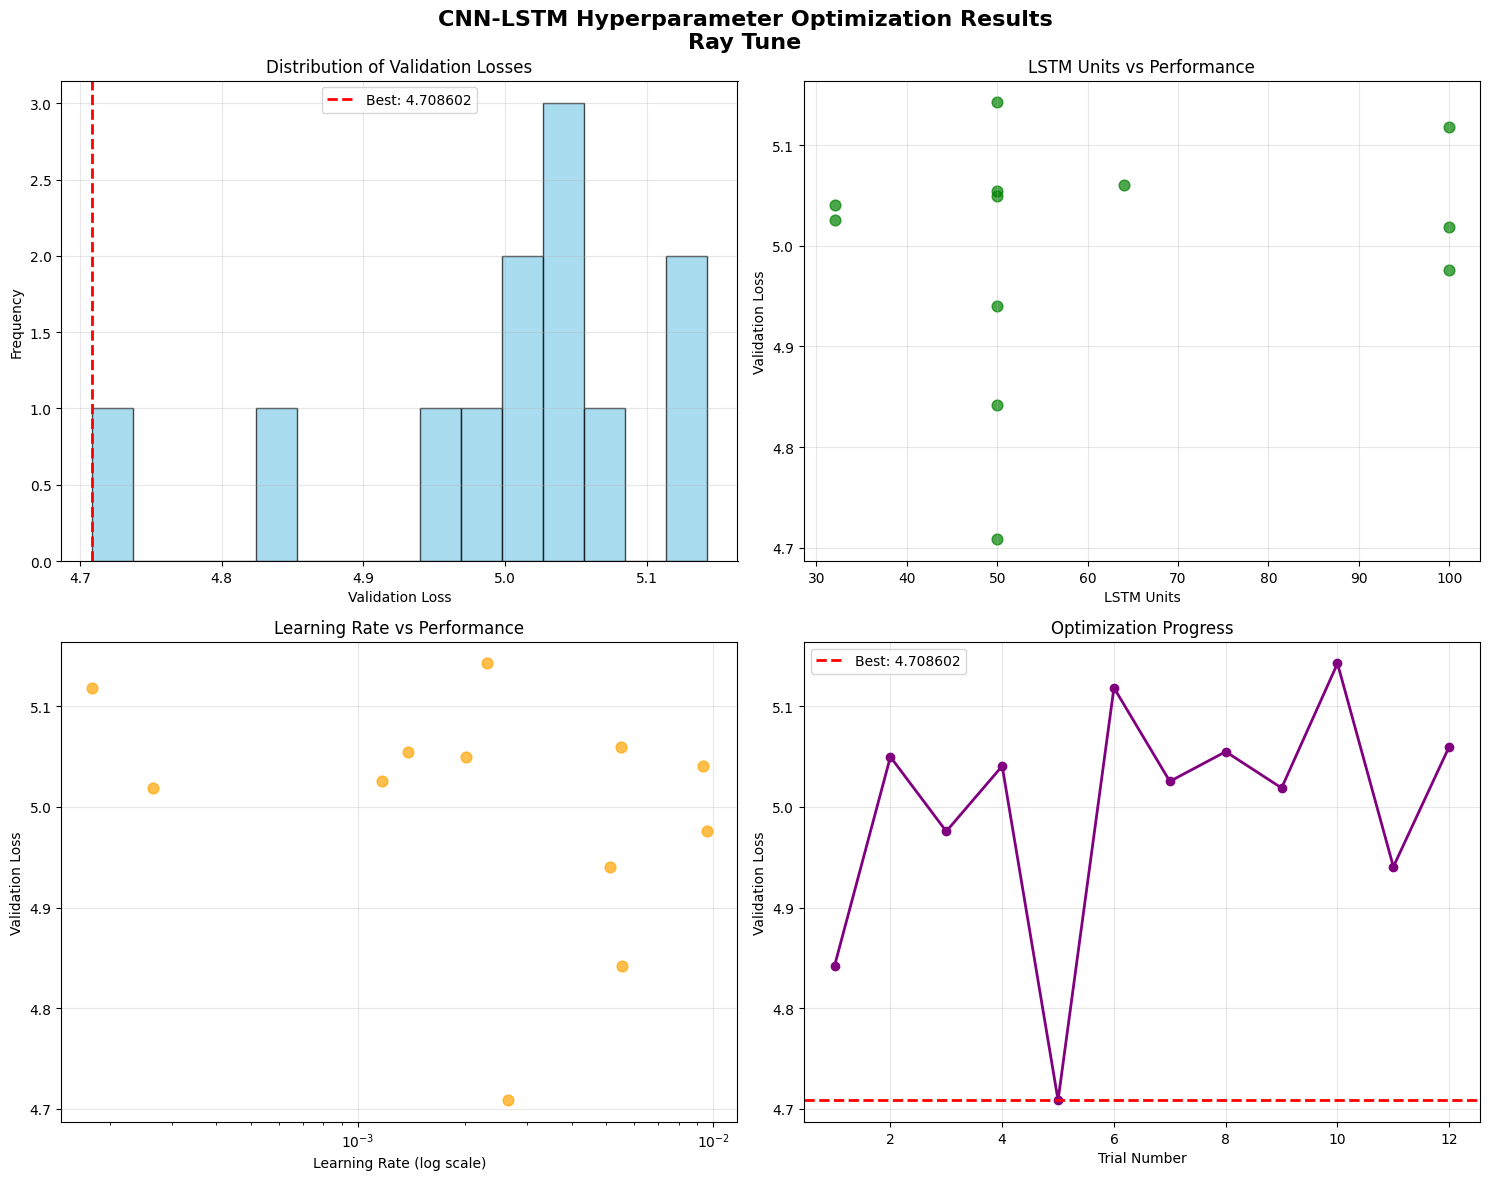


📈 Performance Analysis:
   • Mean validation loss: 4.998004
   • Std validation loss: 0.115419
   • Min validation loss: 4.708602
   • Max validation loss: 5.142337

💾 Results Saved:
   • Best configuration: optimization_results/best_cnn_lstm_config_20250613_162041.json
   • Detailed results: optimization_results/cnn_lstm_hparam_results_20250613_162041.json
   • Trial data (CSV): optimization_results/cnn_lstm_trials_20250613_162041.csv

🎉 Hyperparameter optimization completed successfully!
🏆 Best configuration achieved validation loss: 4.708602

Next steps:
   1. Use the best configuration for final model training
   2. Evaluate on test data
   3. Consider ensembling multiple top configurations


In [14]:
# 📊 Step 8: Results Analysis and Visualization
import json
import pandas as pd
from datetime import datetime

print("📊 Analyzing Optimization Results...")

# Helper function to convert numpy types to native Python types
def convert_numpy_types(obj):
    """Recursively convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_numpy_types(item) for item in obj]
    elif hasattr(obj, 'item'):  # numpy scalars
        return obj.item()
    elif hasattr(obj, 'tolist'):  # numpy arrays
        return obj.tolist()
    else:
        return obj

# Get best configuration and results
best_result = analysis.get_best_trial(metric="val_loss", mode="min")
best_config = best_result.config
best_val_loss = best_result.last_result["val_loss"]

print(f"\n🎯 Optimization Summary:")
print(f"   • Method: Ray Tune")
print(f"   • Total trials: {len(analysis.trials)}")
print(f"   • Successful trials: {len([t for t in analysis.trials if t.status == 'TERMINATED'])}")
print(f"   • Best validation loss: {best_val_loss:.6f}")

# Create comprehensive results visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('CNN-LSTM Hyperparameter Optimization Results\nRay Tune', fontsize=16, fontweight='bold')

# 1. Validation loss distribution
val_losses = [trial.last_result["val_loss"] for trial in analysis.trials if trial.last_result]
axes[0, 0].hist(val_losses, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(best_val_loss, color='red', linestyle='--', linewidth=2, 
                   label=f'Best: {best_val_loss:.6f}')
axes[0, 0].set_xlabel('Validation Loss')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Validation Losses')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. LSTM units vs performance
lstm_units = [trial.config["lstm_units"] for trial in analysis.trials if trial.last_result]
axes[0, 1].scatter(lstm_units, val_losses, alpha=0.7, color='green', s=60)
axes[0, 1].set_xlabel('LSTM Units')
axes[0, 1].set_ylabel('Validation Loss')
axes[0, 1].set_title('LSTM Units vs Performance')
axes[0, 1].grid(True, alpha=0.3)

# 3. Learning rate vs performance
learning_rates = [trial.config["learning_rate"] for trial in analysis.trials if trial.last_result]
axes[1, 0].scatter(learning_rates, val_losses, alpha=0.7, color='orange', s=60)
axes[1, 0].set_xscale('log')
axes[1, 0].set_xlabel('Learning Rate (log scale)')
axes[1, 0].set_ylabel('Validation Loss')
axes[1, 0].set_title('Learning Rate vs Performance')
axes[1, 0].grid(True, alpha=0.3)

# 4. Optimization progress
trial_numbers = list(range(1, len(val_losses) + 1))
axes[1, 1].plot(trial_numbers, val_losses, 'o-', color='purple', markersize=6, linewidth=2)
axes[1, 1].axhline(best_val_loss, color='red', linestyle='--', linewidth=2, 
                   label=f'Best: {best_val_loss:.6f}')
axes[1, 1].set_xlabel('Trial Number')
axes[1, 1].set_ylabel('Validation Loss')
axes[1, 1].set_title('Optimization Progress')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance statistics
print(f"\n📈 Performance Analysis:")
print(f"   • Mean validation loss: {np.mean(val_losses):.6f}")
print(f"   • Std validation loss: {np.std(val_losses):.6f}")
print(f"   • Min validation loss: {np.min(val_losses):.6f}")
print(f"   • Max validation loss: {np.max(val_losses):.6f}")

# Save results to disk
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = "optimization_results"
os.makedirs(results_dir, exist_ok=True)

# Convert numpy types to native Python types for JSON serialization
best_config_serializable = convert_numpy_types(best_config)

# Save best configuration
best_config_file = f"{results_dir}/best_cnn_lstm_config_{timestamp}.json"
with open(best_config_file, 'w') as f:
    json.dump(best_config_serializable, f, indent=2)

print(f"\n💾 Results Saved:")
print(f"   • Best configuration: {best_config_file}")

# Save detailed results
results_summary = {
    "optimization_method": "Ray Tune",
    "timestamp": timestamp,
    "best_config": best_config_serializable,
    "best_val_loss": float(best_val_loss),
    "total_trials": len(analysis.trials),
    "successful_trials": len([t for t in analysis.trials if t.status == 'TERMINATED']),
    "performance_stats": {
        "mean_val_loss": float(np.mean(val_losses)),
        "std_val_loss": float(np.std(val_losses)),
        "min_val_loss": float(np.min(val_losses)),
        "max_val_loss": float(np.max(val_losses))
    }
}

results_file = f"{results_dir}/cnn_lstm_hparam_results_{timestamp}.json"
with open(results_file, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"   • Detailed results: {results_file}")

# Save trial data as CSV for further analysis
trial_data = []
for i, trial in enumerate(analysis.trials):
    if trial.last_result:
        trial_info = {
            "trial_id": i + 1,
            "val_loss": trial.last_result["val_loss"],
            **convert_numpy_types(trial.config)
        }
        trial_data.append(trial_info)

df_results = pd.DataFrame(trial_data)
csv_file = f"{results_dir}/cnn_lstm_trials_{timestamp}.csv"
df_results.to_csv(csv_file, index=False)
print(f"   • Trial data (CSV): {csv_file}")

print(f"\n🎉 Hyperparameter optimization completed successfully!")
print(f"🏆 Best configuration achieved validation loss: {best_val_loss:.6f}")
print(f"\nNext steps:")
print(f"   1. Use the best configuration for final model training")
print(f"   2. Evaluate on test data")
print(f"   3. Consider ensembling multiple top configurations")